In [1]:
# Add Libraries
using CSV
using DataFrames
using Dates
using GaussianMixtures
using StatsPlots
using Statistics
using StatsBase
using Clustering

In [2]:
# Loading data and viewing its first 5 entries
data = CSV.read("OnlineRetail.csv",DataFrame)
first(data,5)

5×8 DataFrame
 Row │ InvoiceNo  StockCode  Description                        Quantity  Invo ⋯
     │ String     String     String?                            Int64     Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 536365     85123A     WHITE HANGING HEART T-LIGHT HOLD…         6  01-1 ⋯
   2 │ 536365     71053      WHITE METAL LANTERN                       6  01-1
   3 │ 536365     84406B     CREAM CUPID HEARTS COAT HANGER            8  01-1
   4 │ 536365     84029G     KNITTED UNION FLAG HOT WATER BOT…         6  01-1
   5 │ 536365     84029E     RED WOOLLY HOTTIE WHITE HEART.            6  01-1 ⋯
                                                               4 columns omitted

### Data Cleaning

In [3]:
# the size and the attribute names
size(data),names(data)

((541909, 8), ["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"])

In [4]:
# Brief description about the data
describe(data)

8×7 DataFrame
 Row │ variable     mean     min                             median   max      ⋯
     │ Symbol       Union…   Any                             Union…   Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ InvoiceNo             536365                                   C581569  ⋯
   2 │ StockCode             10002                                    m
   3 │ Description            4 PURPLE FLOCK DINNER CANDLES           wrongly
   4 │ Quantity     9.55225  -80995                          3.0      80995
   5 │ InvoiceDate           01-02-2011 08:23                         31-10-20 ⋯
   6 │ UnitPrice    4.61111  -11062.1                        2.08     38970.0
   7 │ CustomerID   15287.7  12346                           15152.0  18287
   8 │ Country               Australia                                Unspecif
                                                               3 columns omitted

* The data has 8 attributes.InvoiceNo, Description, StockCode, InvoiceDate, Country are of String type. Quantity and UnitPrice are Integer type values. 
* A peculiar thing to note is that Quantity has negative values. These -ve values corresponds to the Canceled order which are uniquely Identified by their InvoiceNo begining with C as shown below.

In [5]:
# Cancelled Orders
first(filter(row -> row[:Quantity] < 0, data),5)

5×8 DataFrame
 Row │ InvoiceNo  StockCode  Description                       Quantity  Invoi ⋯
     │ String     String     String?                           Int64     Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ C536379    D          Discount                                -1  01-12 ⋯
   2 │ C536383    35004C     SET OF 3 COLOURED  FLYING DUCKS         -1  01-12
   3 │ C536391    22556      PLASTERS IN TIN CIRCUS PARADE          -12  01-12
   4 │ C536391    21984      PACK OF 12 PINK PAISLEY TISSUES        -24  01-12
   5 │ C536391    21983      PACK OF 12 BLUE PAISLEY TISSUES        -24  01-12 ⋯
                                                               4 columns omitted

#### Identify null values

In [6]:
show(mapcols(x -> count(ismissing, x), data),allcols = true)

1×8 DataFrame
 Row │ InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  CustomerID  Country 
     │ Int64      Int64      Int64        Int64     Int64        Int64      Int64       Int64   
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │         0          0         1454         0            0          0      135080        0

##### Remove data entries 

* From the CustomerID column, nearly 25% data entries are missing. Therefore, almost 25% of invoices are not assigned to any customer. 
* These invoices cannot be mapped to any random customers without of lack of knowledge. Therefore, these entries needs to be removed from the dataset.

In [7]:
data = dropmissing(data, :CustomerID)
show(mapcols(x -> count(ismissing, x), data),allcols = true)

1×8 DataFrame
 Row │ InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  CustomerID  Country 
     │ Int64      Int64      Int64        Int64     Int64        Int64      Int64       Int64   
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │         0          0            0         0            0          0           0        0

#### Identify duplicate entries


In [8]:
println("Duplicate values in the data: ",count(nonunique(data)))
# Remove duplicate values from data
unique!(data) 
print("Duplicate values in the data: ",count(nonunique(data)))

Duplicate values in the data: 5225
Duplicate values in the data: 0

####  Removing entries with -ve Quantity values

In [9]:
data=filter(row -> row[:Quantity] > 1, data)
describe(data)

8×7 DataFrame
 Row │ variable     mean     min                             median   max      ⋯
     │ Symbol       Union…   Any                             Union…   Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ InvoiceNo             536365                                   581587   ⋯
   2 │ StockCode             10002                                    POST
   3 │ Description            4 PURPLE FLOCK DINNER CANDLES           ZINC WIR
   4 │ Quantity     15.7718  2                               6.0      80995
   5 │ InvoiceDate           01-02-2011 08:23                         31-10-20 ⋯
   6 │ UnitPrice    2.64381  0.0                             1.65     649.5
   7 │ CustomerID   15196.9  12346                           15046.0  18287
   8 │ Country               Australia                                Unspecif
                                                               3 columns omitted

#### Changing date from string to dateTime in Julia

In [10]:
DATEFORMAT = DateFormat("dd-mm-yyyy HH:MM")
data.InvoiceDate = Date.(data.InvoiceDate,  DATEFORMAT)
describe(data)

8×7 DataFrame
 Row │ variable     mean     min                             median   max      ⋯
     │ Symbol       Union…   Any                             Union…   Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ InvoiceNo             536365                                   581587   ⋯
   2 │ StockCode             10002                                    POST
   3 │ Description            4 PURPLE FLOCK DINNER CANDLES           ZINC WIR
   4 │ Quantity     15.7718  2                               6.0      80995
   5 │ InvoiceDate           2010-12-01                               2011-12- ⋯
   6 │ UnitPrice    2.64381  0.0                             1.65     649.5
   7 │ CustomerID   15196.9  12346                           15046.0  18287
   8 │ Country               Australia                                Unspecif
                                                               3 columns omitted

#### Adding a column "TotalAmount" to store the total money spent by each transaction

In [11]:
data.TotalAmount = data.Quantity .* data.UnitPrice
data.TotalAmount

323127-element Array{Float64,1}:
 15.299999999999999
 20.34
 22.0
 20.34
 20.34
 15.3
 25.5
 11.100000000000001
 11.100000000000001
 54.08
 12.600000000000001
 12.600000000000001
 30.0
  ⋮
 15.0
 15.0
 15.0
 15.0
 15.6
 23.4
 16.6
 10.2
 12.600000000000001
 16.6
 16.6
 14.850000000000001

### Exploratory Data Analysis

##### Total number of customers, products and transactions in the dataset ?


In [12]:
DataFrame(Customers = length(unique(data[!,"CustomerID"])) , Products = length(unique(data[!,"StockCode"])),Transactions= length(unique(data[!,"InvoiceNo"])))  

1×3 DataFrame
 Row │ Customers  Products  Transactions 
     │ Int64      Int64     Int64        
─────┼───────────────────────────────────
   1 │      4328      3572         18257

* The dataset contain the recods of 4328 customers who bought 3572 different items.
* There are $\sim$18,000 transactions which are carried out.

##### Number of products purchased in every transaction

In [13]:
first(sort(combine(groupby(data, [:CustomerID, :InvoiceNo]), nrow => :ProductsPerTransaction),(:CustomerID)),10)

10×3 DataFrame
 Row │ CustomerID  InvoiceNo  ProductsPerTransaction 
     │ Int64       String     Int64                  
─────┼───────────────────────────────────────────────
   1 │      12346  541431                          1
   2 │      12347  537626                         31
   3 │      12347  542237                         29
   4 │      12347  549222                         24
   5 │      12347  556201                         18
   6 │      12347  562032                         22
   7 │      12347  573511                         47
   8 │      12347  581180                         11
   9 │      12348  539318                         17
  10 │      12348  541998                          5

* There are some users who bought only comes one time on the E-commerce platform and purchased one   
  item. The example of this kind of user is customerID 12346.  

* There are some users who frequently buy large number of items per order. The example of this kind of 
  user is customerID 12347.  

##### Number of transactions made by each customer

In [14]:
# transactionsPerCustomer=groupby(data,[:CustomerID,:Country])
# # groupby(data,[:CustomerID,:Country,:InvoiceNo])
transactionsPerCustomer = combine(groupby(data, [:CustomerID,:Country]), :InvoiceNo=>length∘unique)
first(rename!(transactionsPerCustomer, :InvoiceNo_length_unique => :Transactions),10)

10×3 DataFrame
 Row │ CustomerID  Country         Transactions 
     │ Int64       String          Int64        
─────┼──────────────────────────────────────────
   1 │      17850  United Kingdom            34
   2 │      13047  United Kingdom             9
   3 │      12583  France                    15
   4 │      13748  United Kingdom             5
   5 │      15100  United Kingdom             3
   6 │      15291  United Kingdom            14
   7 │      14688  United Kingdom            21
   8 │      17809  United Kingdom            12
   9 │      15311  United Kingdom            91
  10 │      16098  United Kingdom             7

In [15]:
# Top 5 customers
first(sort(transactionsPerCustomer,(:Transactions),rev=true),5)

5×3 DataFrame
 Row │ CustomerID  Country         Transactions 
     │ Int64       String          Int64        
─────┼──────────────────────────────────────────
   1 │      14911  EIRE                     197
   2 │      12748  United Kingdom           177
   3 │      17841  United Kingdom           120
   4 │      13089  United Kingdom            97
   5 │      15311  United Kingdom            91

* The table above hows that the maximum number of transactions(invoices),197, were placed by the customer 14911 in EIRE. 
* Among our top 5 customers, United Kingdom customers secured the last 4 positions indicating that, it can be a potential market for high growth and profit. Therefore, investing more in UK would be beneficial.

##### Money spent by each customers

In [16]:
moneySpent = combine(groupby(data,[:CustomerID,:Country]),:TotalAmount)
#Top 5
first(sort(moneySpent,(:TotalAmount),rev=true),5)

5×3 DataFrame
 Row │ CustomerID  Country         TotalAmount  
     │ Int64       String          Float64      
─────┼──────────────────────────────────────────
   1 │      16446  United Kingdom      1.6847e5
   2 │      12346  United Kingdom  77183.6
   3 │      15098  United Kingdom  38970.0
   4 │      17450  United Kingdom   7144.72
   5 │      15749  United Kingdom   6539.4

* The table depicts the total amount invested by each customer along with its country. For instance, CustomerID 16446 spent the most amount among the rest.
* Moreover, UK customers were among the top 5 who spent the most amount. 

##### Number of transactions per Month

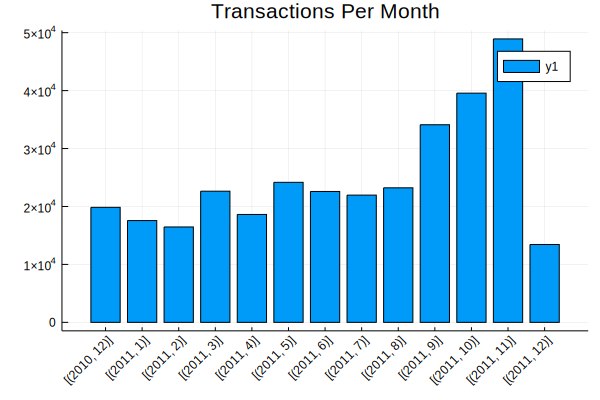

In [17]:
data[!, :month] = yearmonth.(data[!, :InvoiceDate])
transactionsPerMonth = combine(groupby(data, :month),nrow)
transactionsPerMonth[!, :month]=map(x->string(x), eachrow(transactionsPerMonth.month))
bar(transactionsPerMonth.month,
    transactionsPerMonth.nrow,
    title = "Transactions Per Month",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

* According to the graph above, most transactions were in November,2011 in a time frame of 11 months.
* Unfortunately we only have 9 days of data for December, 2011. But we hope for a monotonic increase.
* The boom in sales from September, 2011 to November 2011 can be owed to the Holiday season.

##### Number of transactions per Day

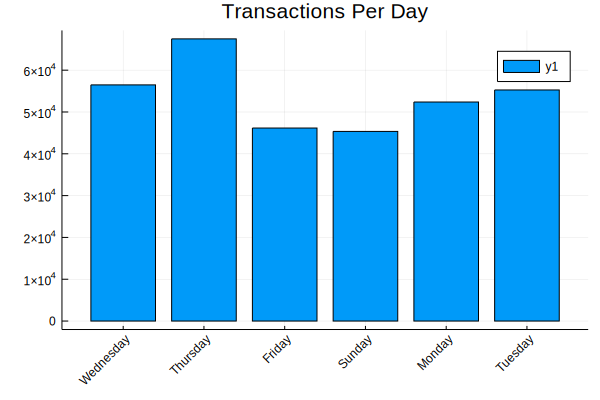

In [18]:
data[!, :day] = dayname.(data[!, :InvoiceDate])
transactionsPerDay = combine(groupby(data, :day),nrow)
bar(transactionsPerDay.day,
    transactionsPerDay.nrow,
    title = "Transactions Per Day",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])


* The above bar graph depits the cummulative transcations per week throughout the time frame(Dec,2010 to Dec, 2011).
* According to the bar graph above, the most and the least transcations made was on Thursdays and Sundays respectively.

##### Unit Price Description

In [19]:
# Unit Price
describe(data.UnitPrice)

Summary Stats:
Length:         323127
Missing Count:  0
Mean:           2.643813
Minimum:        0.000000
1st Quartile:   0.850000
Median:         1.650000
3rd Quartile:   2.950000
Maximum:        649.500000
Type:           Float64


We see that there are unit price = 0 (FREE items)

There are some free items given to customers from time to time.

In [20]:
# Distribution of Unit Price
bp1 = boxplot(data.UnitPrice)
StatsPlots.plot(bp1)

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: Set([:top_margin, :group, :background_color, :yforeground_color_text, :yguidefontcolor, :seriesalpha, :legendfontcolor, :seriescolor, :ztick_direction, :zlims, :overwrite_figure, :xguidefonthalign, :normalize, :linestyle, :xflip, :fillcolor, :ygrid, :background_color_inside, :zguidefonthalign, :bins, :yscale, :xtickfontcolor, :xguide, :fillalpha, :tick_direction, :yguidefontsize, :legendfontfamily, :foreground_color, :xtickfonthalign, :x, :ytickfontrotation, :legend, :discrete_values, :ytick_direction, :xguidefontrotation, :ribbon, :tickfontrotation, :xdiscrete_values, :legendtitle, :xgridstyle, :orientation, :gridstyle, :markersize, :camera, :xforeground_color_grid, :quiver, :zticks, :markerstrokecolor, :ztickfontrotation, :ztickfonthalign, :legendfonthalign, :xtickfontsize, :levels, :zgridstyle, :foreground_color_border, :zguidefontvalign, :marker_z, :markerstrokealpha, :markeralpha, :tickfontvalign

* The box plot above shows the distribution of the Unit Price. It indicates that 75\% prices of each products are below \$3, i.e. the third Quartile.
* However, there are few products that are prices very high as shown by the Outliers in the plot. The maximum price of a product is \$649.5 . These products may impact the overall sales so these outliers are not removed.

In [21]:
data_free = filter(row -> row[:UnitPrice]==0 , data)

27×11 DataFrame
 Row │ InvoiceNo  StockCode  Description                        Quantity  Invo ⋯
     │ String     String     String?                            Int64     Date ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 539263     22580      ADVENT CALENDAR GINGHAM SACK              4  2010 ⋯
   2 │ 539722     22423      REGENCY CAKESTAND 3 TIER                 10  2010
   3 │ 540372     22090      PAPER BUNTING RETROSPOT                  24  2011
   4 │ 540372     22553      PLASTERS IN TIN SKULLS                   24  2011
   5 │ 543599     84535B     FAIRY CAKES NOTEBOOK A6 SIZE             16  2011 ⋯
   6 │ 547417     22062      CERAMIC BOWL WITH LOVE HEART DES…        36  2011
   7 │ 548318     22055      MINI CAKE STAND  HANGING STRAWBE…         5  2011
   8 │ 548871     22162      HEART GARLAND RUSTIC PADDED               2  2011
   9 │ 553000     47566      PARTY BUNTING                             4  2011 ⋯
  10 │ 554037     22619      SET OF 6 SOLDIER SKITTLES                80  2011
  11 │ 561669     22960      JAM MAKING SET WITH JARS                 11  2011
  ⋮  │     ⋮          ⋮                      ⋮                     ⋮           ⋱
  18 │ 572893     21208      PASTEL COLOUR HONEYCOMB FAN               5  2011
  19 │ 574138     23234      BISCUIT TIN VINTAGE CHRISTMAS           216  2011 ⋯
  20 │ 574175     22065      CHRISTMAS PUDDING TRINKET POT            12  2011
  21 │ 574469     22385      JUMBO BAG SPACEBOY DESIGN                12  2011
  22 │ 574879     22625      RED KITCHEN SCALES                        2  2011
  23 │ 575579     22437      SET OF 9 BLACK SKULL BALLOONS            20  2011 ⋯
  24 │ 575579     22089      PAPER BUNTING VINTAGE PAISLEY            24  2011
  25 │ 577129     22464      HANGING METAL HEART LANTERN               4  2011
  26 │ 577314     23407      SET OF 2 TRAYS HOME SWEET HOME            2  2011
  27 │ 578841     84826      ASSTD DESIGN 3D PAPER STICKERS        12540  2011 ⋯
                                                    7 columns and 6 rows omitted

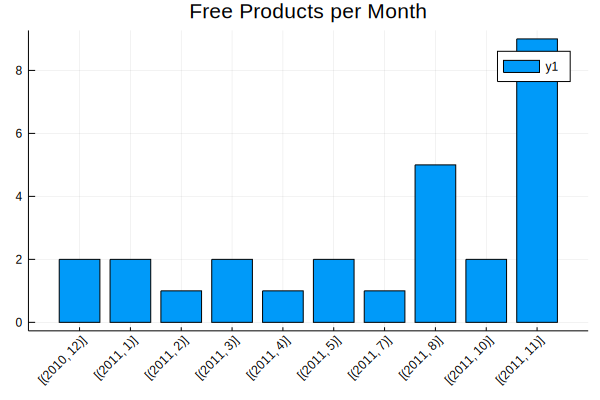

In [22]:
data_free[!, :month] = yearmonth.(data_free[!, :InvoiceDate])
freeOrder = combine(groupby(data_free, :month),nrow)
freeOrder[!, :month]=map(x->string(x), eachrow(freeOrder.month))
bar(freeOrder.month,
    freeOrder.nrow,
    title = "Free Products per Month",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

* On average, the company gave out 2 FREE products to customers each month except in June and September in 2011
* Because of the Thanksgiving in August and, the holiday season in November, more and more products were given free
* Free products given to customers in November were almost 3 folds to the average free products given during the rest of the time frame

##### Products Sold per Country

Unique countries in the dataset: 37

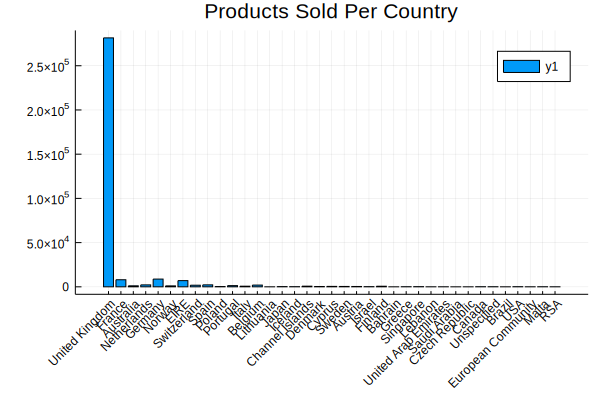

In [23]:
print("Unique countries in the dataset: ",length(unique(data[!,"Country"])))
orderPerCountry =   combine(groupby(data, :Country), nrow)
bar(orderPerCountry.Country,
    orderPerCountry.nrow,
    title = "Products Sold Per Country",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

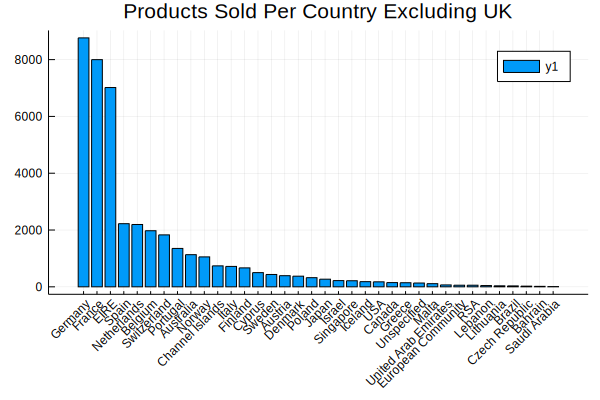

In [24]:
delete!(orderPerCountry, 1)
orderPerCountry= sort(orderPerCountry,:nrow,rev=true)
bar(orderPerCountry.Country,
    orderPerCountry.nrow,
    title = "Products Sold Per Country Excluding UK",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])


* Maximum sales occured in UK followed by France , EIRE and Spain. 
* Therefore, investing the UK will surely lead to higher profits.

##### Money Spent by Each Country

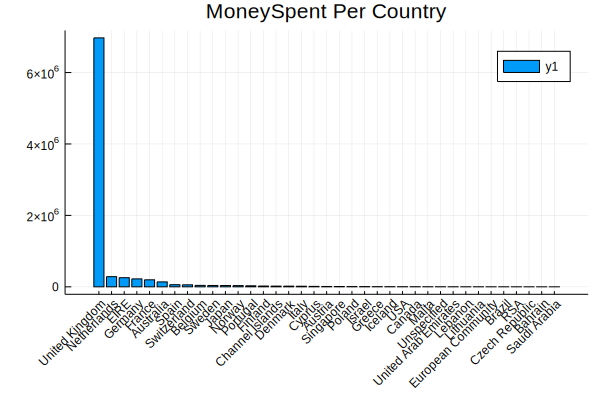

In [25]:
moneyPerCount = sort(combine(groupby(data, [:Country]), :TotalAmount => sum),:TotalAmount_sum,rev=true)
bar(moneyPerCount.Country,
    moneyPerCount.TotalAmount_sum,
    title = "MoneySpent Per Country",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])


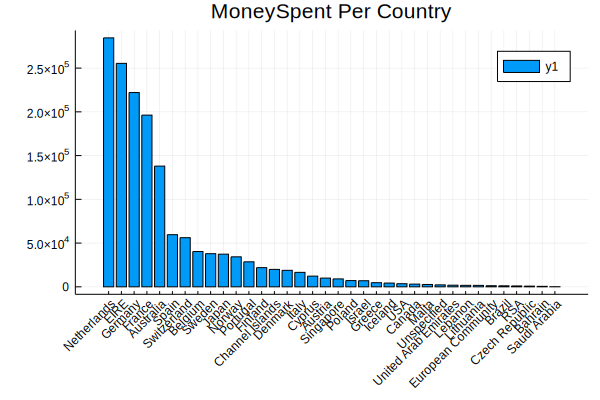

In [26]:
delete!(moneyPerCount, 1)
bar(moneyPerCount.Country,
    moneyPerCount.TotalAmount_sum,
    title = "MoneySpent Per Country",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

* UK ranked top among the other countries in terms of money spent.
* This trend seems to continue in all European countries as depicted by the second graph. 
* Saudi Arabia spent the least money and therefore, we should re-consider the idea of investing there.

#### Customer Segmentation

RFM Technique:
* R (Recency) : Number of days since last purchase
* F (Frequency) : Number of transactions
* M (Monetary) : Total amount of transactions (revenue contributed)

In [27]:
# The dataframe contains the amount spent by a each customer in each transaction(invoice)
totalOrder = combine(groupby(data,[:InvoiceNo,:CustomerID, :InvoiceDate]),:TotalAmount => sum)
# Reference Date :
REFERENCE_DATE, _ = findmax(data.InvoiceDate)
println("Reference Data : " ,REFERENCE_DATE)
first(sort(totalOrder,:CustomerID),6)

Reference Data : 2011-12-09


6×4 DataFrame
 Row │ InvoiceNo  CustomerID  InvoiceDate  TotalAmount_sum 
     │ String     Int64       Date         Float64         
─────┼─────────────────────────────────────────────────────
   1 │ 541431          12346  2011-01-18          77183.6
   2 │ 537626          12347  2010-12-07            711.79
   3 │ 542237          12347  2011-01-26            475.39
   4 │ 549222          12347  2011-04-07            636.25
   5 │ 556201          12347  2011-06-09            382.52
   6 │ 562032          12347  2011-08-02            584.91

In [28]:
# Recency
totalOrder.Recency = Dates.value.(REFERENCE_DATE .- totalOrder.InvoiceDate)
sort(totalOrder,:CustomerID)
customer = combine(groupby(totalOrder,[:CustomerID]),:Recency => minimum)
rename!(customer, :Recency_minimum => :Recency)

# Frequency
customer.Frequency = combine(groupby(totalOrder,[:CustomerID]),nrow => :Frequency).Frequency

# Monetary
customer.Monetary = combine(groupby(totalOrder,[:CustomerID]),:TotalAmount_sum => sum).TotalAmount_sum_sum

# Customer Dataset
first(customer,10)

10×4 DataFrame
 Row │ CustomerID  Recency  Frequency  Monetary 
     │ Int64       Int64    Int64      Float64  
─────┼──────────────────────────────────────────
   1 │      17850      372         34   5391.21
   2 │      13047       56          9   3232.59
   3 │      12583        2         15   7227.38
   4 │      13748       95          5    935.5
   5 │      15100      333          3    876.0
   6 │      15291       25         14   4598.4
   7 │      14688        7         21   5407.58
   8 │      17809       16         12   5397.46
   9 │      15311        0         91  58602.2
  10 │      16098       87          7   1978.23

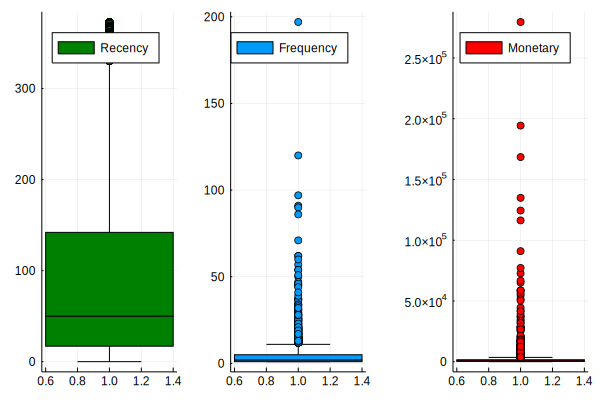

In [29]:
 # Analysis of RFM
bp1 = boxplot(customer.Recency,label = "Recency",color="green")
bp2 = boxplot(customer.Frequency,label = "Frequency")
bp3 = boxplot(customer.Monetary,label = "Monetary",color="red")
plot(bp1,bp2,bp3,layout=(1,3))

* Monetary values contains large number of Outliers that needs to be removed as they will try to skew the dataset leading to improper cluster formation.
* Outliers outside the 1.5* IQR(Inter Quartile Range) range will be removed.

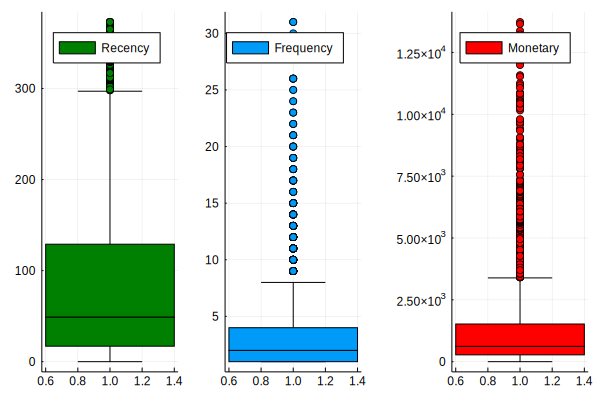

In [30]:
# Removing Outliers in Recency values
quartile1 = quantile!(customer.Recency,0.05)
quartile3 = quantile!(customer.Recency,0.95)
IQR = quartile3 - quartile1
customer = filter(row -> ((row[:Recency] >= quartile1-1.5*IQR)  & (row[:Recency] <= quartile3 + 1.5*IQR)),customer)

# Removing Outliers in Frequency values
quartile1 = quantile!(customer.Frequency,0.05)
quartile3 = quantile!(customer.Frequency,0.95)
IQR = quartile3 - quartile1
customer = filter(row -> ((row[:Frequency] >= quartile1-1.5*IQR)  & (row[:Frequency] <= quartile3 + 1.5*IQR)),customer)


# Removing Outliers in Monetary values
quartile1 = quantile!(customer.Monetary,0.05)
quartile3 = quantile!(customer.Monetary,0.95)
IQR = quartile3 - quartile1
customer = filter(row -> ((row[:Monetary] >= quartile1-1.5*IQR)  & (row[:Monetary] <= quartile3 + 1.5*IQR)),customer)

bp1 = boxplot(customer.Recency,label = "Recency",color="green")
bp2 = boxplot(customer.Frequency,label = "Frequency")
bp3 = boxplot(customer.Monetary,label = "Monetary",color="red")
plot(bp1,bp2,bp3,layout=(1,3))

#### Feature Scaling

* The customer RFM dataset has different scales for different features. Feature Scaling Algorithms will scale all the features in a fixed range so that no feature can dominate others.
* Standardization technique is used to perform feature scaling on the customer dataset. It is a very effective technique that re-scales a feature value so that it has distribution with 0 mean value and variance equals to 1(Normal Distribution).

In [31]:
# rfm = [customer[!,[:Recency,:Frequency,:Monetary]]]
# typeof(rfm)

rfmMatrix = convert(Matrix, customer[:,2:4])
transformedData = fit(ZScoreTransform, rfmMatrix, dims=1)
X = StatsBase.transform(transformedData, rfmMatrix)

4229×3 Array{Float64,2}:
 -0.356017  -0.407083  -0.318697
 -0.924123  -0.678108  -0.695579
 -0.924123  -0.678108  -0.67798
 -0.924123  -0.678108  -0.689474
 -0.913404  -0.678108  -0.680177
 -0.913404  -0.678108  -0.709052
 -0.913404  -0.678108  -0.680719
 -0.913404  -0.678108  -0.682273
 -0.924123  -0.678108  -0.714614
 -0.913404  -0.678108  -0.704076
 -0.924123  -0.678108  -0.691554
 -0.913404  -0.678108  -0.683235
 -0.913404  -0.678108  -0.684308
  ⋮                    
  2.99902    3.6583     4.35388
  3.07405    3.11625    5.00974
  3.07405    4.47137    5.1459
  2.99902    3.92932    5.1151
  3.07405    3.11625    4.5065
  2.99902    4.47137    5.47168
  2.99902    3.6583     6.13519
  3.07405    4.20035    6.56726
  2.9883     7.45265    6.21296
  3.07405    3.92932    6.11151
  2.9883     3.6583     3.86082
  3.07405    5.01343    6.68246

#### Clustering using GMM

In [32]:
n_components_range = collect(2:4)
cv_types = [:diag, :full]
for cv_type in cv_types
    for n_components in n_components_range
        
        #Kmeans Initialization of Centers
        gmm = GMM(n_components, X; method=:kmeans, kind=cv_type, nInit=50, nIter=10, nFinal=10)
        
        # Training GMM
        em!(gmm, X; nIter = 10, varfloor=1e-3)
        println(history(gmm))
    end
       
end

┌ Info: Initializing GMM, 2 Gaussians diag covariance 3 dimensions using 4229 data points
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:79


K-means converged with 11 iterations (objv = 2103.353247157621)


┌ Info: K-means with 2000 data points using 11 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:140


History[27-03-2021 03:31:00: Initializing GMM, 2 Gaussians diag covariance 3 dimensions using 4229 data points
, 27-03-2021 03:31:03: K-means with 2000 data points using 11 iterations
250.0 data points per parameter
, 27-03-2021 03:31:06: iteration 1, average log likelihood -0.713354
, 27-03-2021 03:31:06: iteration 2, average log likelihood -0.671854
, 27-03-2021 03:31:06: iteration 3, average log likelihood -0.646261
, 27-03-2021 03:31:06: iteration 4, average log likelihood -0.634211
, 27-03-2021 03:31:06: iteration 5, average log likelihood -0.629918
, 27-03-2021 03:31:06: iteration 6, average log likelihood -0.628343
, 27-03-2021 03:31:06: iteration 7, average log likelihood -0.627717
, 27-03-2021 03:31:06: iteration 8, average log likelihood -0.627450
, 27-03-2021 03:31:06: iteration 9, average log likelihood -0.627331
, 27-03-2021 03:31:06: iteration 10, average log likelihood -0.627276
, 27-03-2021 03:31:06: EM with 4229 data points 10 iterations avll -0.627276
325.3 data point

┌ Info: Initializing GMM, 3 Gaussians diag covariance 3 dimensions using 4229 data points
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:79



History[27-03-2021 03:31:07: Initializing GMM, 3 Gaussians diag covariance 3 dimensions using 4229 data points
, 27-03-2021 03:31:07: K-means with 3000 data points using 12 iterations
250.0 data points per parameter
, 27-03-2021 03:31:07: iteration 1, average log likelihood -0.528581
, 27-03-2021 03:31:07: iteration 2, average log likelihood -0.510923
, 27-03-2021 03:31:07: iteration 3, average log likelihood -0.503524
, 27-03-2021 03:31:07: iteration 4, average log likelihood -0.499504
, 27-03-2021 03:31:07: iteration 5, average log likelihood -0.496780
, 27-03-2021 03:31:07: iteration 6, average log likelihood -0.494641
, 27-03-2021 03:31:07: iteration 7, average log likelihood -0.492745
, 27-03-2021 03:31:07: iteration 8, average log likelihood -0.490943
, 27-03-2021 03:31:07: iteration 9, average log likelihood -0.489202
, 27-03-2021 03:31:07: iteration 10, average log likelihood -0.487531
, 27-03-2021 03:31:07: EM with 4229 data points 10 iterations avll -0.487531
211.4 data poin

┌ Info: K-means with 3000 data points using 12 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:140
┌ Info: Initializing GMM, 4 Gaussians diag covariance 3 dimensions using 4229 data points
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:79



History[27-03-2021 03:31:07: Initializing GMM, 4 Gaussians diag covariance 3 dimensions using 4229 data points
, 27-03-2021 03:31:07: K-means with 4000 data points using 33 iterations
250.0 data points per parameter
, 27-03-2021 03:31:07: iteration 1, average log likelihood -0.299891
, 27-03-2021 03:31:07: iteration 2, average log likelihood -0.265265
, 27-03-2021 03:31:07: iteration 3, average log likelihood -0.247680
, 27-03-2021 03:31:07: iteration 4, average log likelihood -0.242039
, 27-03-2021 03:31:07: iteration 5, average log likelihood -0.240046
, 27-03-2021 03:31:07: iteration 6, average log likelihood -0.238967
, 27-03-2021 03:31:07: iteration 7, average log likelihood -0.238263
, 27-03-2021 03:31:07: iteration 8, average log likelihood -0.237767
, 27-03-2021 03:31:07: iteration 9, average log likelihood -0.237407
, 27-03-2021 03:31:07: iteration 10, average log likelihood -0.237140
, 27-03-2021 03:31:07: EM with 4229 data points 10 iterations avll -0.237140
156.6 data poin

┌ Info: K-means with 4000 data points using 33 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:140
┌ Info: Initializing GMM, 2 Gaussians diag covariance 3 dimensions using 4229 data points
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:79


┌ Info: K-means with 2000 data points using 11 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:140


History[27-03-2021 03:31:07: Initializing GMM, 2 Gaussians diag covariance 3 dimensions using 4229 data points
, 27-03-2021 03:31:07: K-means with 2000 data points using 11 iterations
250.0 data points per parameter
, 27-03-2021 03:31:09: iteration 1, average log likelihood -0.323420
, 27-03-2021 03:31:09: iteration 2, average log likelihood -0.309912
, 27-03-2021 03:31:09: iteration 3, average log likelihood -0.306333
, 27-03-2021 03:31:09: iteration 4, average log likelihood -0.304848
, 27-03-2021 03:31:09: iteration 5, average log likelihood -0.304138
, 27-03-2021 03:31:09: iteration 6, average log likelihood -0.303771
, 27-03-2021 03:31:09: iteration 7, average log likelihood -0.303572
, 27-03-2021 03:31:09: iteration 8, average log likelihood -0.303461
, 27-03-2021 03:31:09: iteration 9, average log likelihood -0.303397
, 27-03-2021 03:31:09: iteration 10, average log likelihood -0.303360
, 27-03-2021 03:31:09: EM with 4229 data points 10 iterations avll -0.303360
222.6 data point

┌ Info: Initializing GMM, 3 Gaussians diag covariance 3 dimensions using 4229 data points
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:79
┌ Info: K-means with 3000 data points using 13 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:140


History[27-03-2021 03:31:09: Initializing GMM, 3 Gaussians diag covariance 3 dimensions using 4229 data points
, 27-03-2021 03:31:10: K-means with 3000 data points using 13 iterations
250.0 data points per parameter
, 27-03-2021 03:31:10: iteration 1, average log likelihood -0.251078
, 27-03-2021 03:31:10: iteration 2, average log likelihood -0.244197
, 27-03-2021 03:31:10: iteration 3, average log likelihood -0.241534
, 27-03-2021 03:31:10: iteration 4, average log likelihood -0.239588
, 27-03-2021 03:31:10: iteration 5, average log likelihood -0.237930
, 27-03-2021 03:31:10: iteration 6, average log likelihood -0.236470
, 27-03-2021 03:31:10: iteration 7, average log likelihood -0.235170
, 27-03-2021 03:31:10: iteration 8, average log likelihood -0.234000
, 27-03-2021 03:31:10: iteration 9, average log likelihood -0.232938
, 27-03-2021 03:31:10: iteration 10, average log likelihood -0.231977
, 27-03-2021 03:31:10: EM with 4229 data points 10 iterations avll -0.231977
145.8 data point

┌ Info: Initializing GMM, 4 Gaussians diag covariance 3 dimensions using 4229 data points
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:79


K-means converged with 36 iterations (objv = 1516.3706529780188)


┌ Info: K-means with 4000 data points using 36 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures C:\Users\Lenovo\.julia\packages\GaussianMixtures\1pQcF\src\train.jl:140


LoadError: [91mPosDefException: matrix is not positive definite; Cholesky factorization failed.[39m